### Based on the same file offered by Airbnb of apartments available in Barcelona during 2019.

http://data.insideairbnb.com/spain/catalonia/barcelona/2019-11-09/visualisations/listings.csv


## 1) We want to make categories for the apartments: **Really cheap** (cheaper than one standard deviation of the price distribution ─we assume it Normal─ to the lower side), **Cheap** (between the really cheap ones and the average price), **Expensive** (between the average and one standard deviation to higher side), and **Really expensive** (more than one standard deviation to the higher side).

## How many apartments have each category?

In [107]:
import pandas as pd
import copy
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier

In [50]:
aibnb_data = pd.read_csv("./listings.csv")
aibnb_data['reviews_per_month'] = aibnb_data['reviews_per_month'].fillna(0)
aibnb_data.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,18666,Flat with Sunny Terrace,71615,Mireia And Maria,Sant Martí,el Camp de l'Arpa del Clot,41.40889,2.18555,Entire home/apt,130,3,1,2015-10-10,0.02,30,304
1,18674,Huge flat for 8 people close to Sagrada Familia,71615,Mireia And Maria,Eixample,la Sagrada Família,41.40420,2.17306,Entire home/apt,60,1,20,2019-10-19,0.25,30,312
2,23197,FORUM DELUXE 5 MINS WALK CCIB CENTER & SEA!,90417,Etain (Marnie),Sant Martí,el Besòs i el Maresme,41.41203,2.22114,Entire home/apt,210,3,51,2019-09-29,0.48,2,359
3,25786,NICE ROOM AVAILABLE IN THE HEART OF GRACIA,108310,Pedro,Gràcia,la Vila de Gràcia,41.40145,2.15645,Private room,32,1,268,2019-11-06,2.38,1,46
4,31958,"Gaudi Attic 1, Friendly Rentals",136853,Fidelio,Gràcia,el Camp d'en Grassot i Gràcia Nova,41.40950,2.15938,Entire home/apt,60,1,182,2019-10-16,1.71,39,324


Price standard deviation:  478.9565465162187 way too high, I will explore the data a bit.


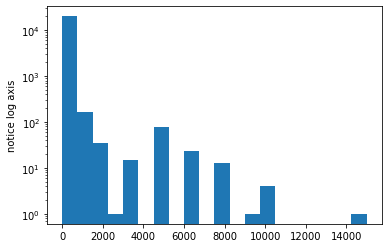

Price mean:  134.58742901899353 2 standard deviations limit:  -823.3256640134439 , 1092.5005220514308
There are  184 rooms beein more than 2 standard deviations away from the mean.


In [19]:
price_standard_deviation = np.std(aibnb_data["price"])
print("Price standard deviation: ",price_standard_deviation, "way too high, I will explore the data a bit.")
plt.hist(aibnb_data["price"], log=1, bins=20)
plt.ylabel("notice log axis")
plt.show()
pme = np.mean(aibnb_data["price"])
print("Price mean: ",pme , "2 standard deviations limit: ", pme -2*price_standard_deviation,",",pme +2*price_standard_deviation)
too_expensive = aibnb_data[aibnb_data["price"]> pme +2*price_standard_deviation]
print("There are ",len(too_expensive), "rooms beein more than 2 standard deviations away from the mean.")

### I will remove 184 rooms from the analisis as they are more than 2 standard distributions away from the mean, so I will consider them as outliers.

Price standard deviation:  17.73421840145181


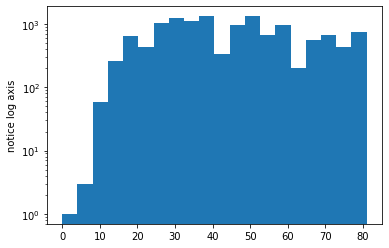

Price mean:  45.30076406575596 standard deviations limit:  27.566545664304154 , 63.03498246720777


/home/jordi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,name,price,cat_price
1,18674,Huge flat for 8 people close to Sagrada Familia,60,Expensive
3,25786,NICE ROOM AVAILABLE IN THE HEART OF GRACIA,32,Cheap
4,31958,"Gaudi Attic 1, Friendly Rentals",60,Expensive
5,32471,"Gaudi Attic 2, Friendly Rentals",70,Really expensive
6,32615,"Sunny room, top floor with 2 terraces!",30,Cheap


In [76]:
aibnb_data = aibnb_data[aibnb_data["price"]<= pme +2*price_standard_deviation]
price_standard_deviation = np.std(aibnb_data["price"])
print("Price standard deviation: ",price_standard_deviation)
plt.hist(aibnb_data["price"], log=1, bins=20)
plt.ylabel("notice log axis")
plt.show()
pme = np.mean(aibnb_data["price"])
print("Price mean: ",pme , "standard deviations limit: ", pme -price_standard_deviation,",",pme +price_standard_deviation)

categorized_prizes = []
for price in aibnb_data["price"]:
    if price < pme -price_standard_deviation:
        categorized_prizes.append("Really cheap")
    elif price < pme:
        categorized_prizes.append("Cheap")
    elif price < pme +price_standard_deviation:
        categorized_prizes.append("Expensive")
    else:
        categorized_prizes.append("Really expensive")
aibnb_data["cat_price"] = categorized_prizes
aibnb_data[["id","name","price","cat_price"]].head()

In [77]:
print("By the new categorized prices, there are:")
for i in set(aibnb_data["cat_price"]):
    print("  ",list(aibnb_data["cat_price"]).count(i),i+" rooms")

By the new categorized prices, there are:
   4841 Cheap rooms
   2451 Really expensive rooms
   3404 Expensive rooms
   2261 Really cheap rooms


## 2) We want to know what feature defines better the price between the following features:
### neighbourhood_group, neighbourhood, latitude, longitude, room_type, minimum_nights, number_of_reviews, reviews_per_month, availability_365.

## Make a Decision Tree Classifier, plot the resulting decision tree and draw your conclusions.

In [78]:
train_set = aibnb_data.sample(1000, random_state=1234)
clf = tree.DecisionTreeClassifier()
airbnb_feteatures_defining_price = train_set[["neighbourhood_group","neighbourhood","latitude","longitude","room_type","minimum_nights","number_of_reviews","reviews_per_month","availability_365"]]
airbnb_feteatures_defining_price=pd.get_dummies(airbnb_feteatures_defining_price)
clf.fit(airbnb_feteatures_defining_price, train_set[["cat_price"]])
airbnb_feteatures_defining_price.head()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,availability_365,neighbourhood_group_Ciutat Vella,neighbourhood_group_Eixample,neighbourhood_group_Gràcia,neighbourhood_group_Horta-Guinardó,...,neighbourhood_la Verneda i la Pau,neighbourhood_la Vila Olímpica del Poblenou,neighbourhood_la Vila de Gràcia,neighbourhood_les Corts,neighbourhood_les Roquetes,neighbourhood_les Tres Torres,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room
18197,41.38317,2.14611,1,3,1.38,75,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
5100,41.39943,2.16102,31,61,1.47,122,0,0,1,0,...,0,0,1,0,0,0,1,0,0,0
19515,41.37838,2.19170,1,0,0.00,110,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
16684,41.38154,2.17544,3,0,0.00,84,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0
13275,41.37344,2.15452,2,36,4.22,174,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


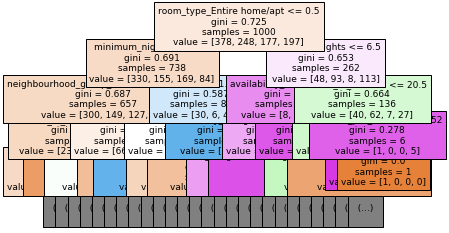

In [80]:
plt.figure()
tree.plot_tree(clf, filled=True,max_depth=4,fontsize= 9, feature_names= airbnb_feteatures_defining_price.columns)
plt.show()

The first variable my desition tree uses to separete data is room_type_Entire home/apt. This variable, created with pd.get_dummies indicates if the ofert is for an entire home/apartment or not.

I had to use that format change because sklearn tree classifier can not handle categorical data in the predictors. In theory, as the data is conserved, this change of format does not influence the final model performance. However it does influence the interpretation of the nodes.

Lets start from the begining: what does "defines better the price" means?

Imagine the we had the folowing simplified data:

In [93]:
silly_data=pd.DataFrame([[1,4, "expensive"],[0,4,"really cheap"],[1,1, "cheap"],[0,2,"really cheap"],[1,1, "cheap"],[1,0.5, "really cheap"],[1,10, "really expensive"],[0,10, "really cheap"],[1,1, "cheap"],[1,1, "cheap"],[1,10, "really expensive"],[1,10, "really expensive"]],columns=["have roof", "number of beds","cat_price"])
silly_data

,have roof,number of beds,cat_price
0,1,4.0,expensive
1,0,4.0,really cheap
2,1,1.0,cheap
3,0,2.0,really cheap
4,1,1.0,cheap
5,1,0.5,really cheap
6,1,10.0,really expensive
7,0,10.0,really cheap
8,1,1.0,cheap
9,1,1.0,cheap


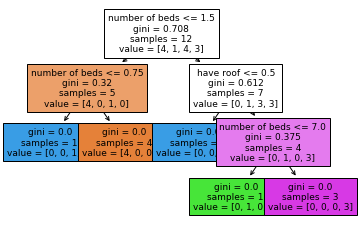

In [94]:
silly_clf = tree.DecisionTreeClassifier()
silly_clf.fit(silly_data[["have roof", "number of beds"]], silly_data[["cat_price"]])
plt.figure()
tree.plot_tree(silly_clf, filled=True,fontsize= 9, feature_names= ["have roof", "number of beds"])
plt.show()

In that case, having no roof determines the room will be really cheap, no matter the number of beds. However, most oferts do include roof, in wich case the price is really correlated to the number of beds. 

So despite the absense of roof directly determining the price, if only one variable could be used to try to gess the price, one would have a higher probability to win using beds # and assume it will have roof.

That same fact is probably aplying to neighbourhoods: maybe beeing on a detemined area almost complitely determines price, but most oferts are not in that area.

But, in the example there were only 2 categeries, there are more than 2 neighbourhoods! So imagine the folowing situation: the price is fully determined by neighbourhood, and we have an extra variable somehow corelated with the price.

Obiously, the correct aproach in this case would be to look the neighbourhood and ignore the other variable.

However, dessicion trees are binary, they can not give a diferent answer for neighbourhood so their ideal first step would be to see if the input belongs to a group of neighbourhoods or not. That would not nessesarily give perfect accuracy and could be outperformed by some linear model or similar using the extra variable.

Moreover, the desicion tree implementatio I'm using does not seem to have a way to get the ideal group of neighbourhoods as it does not accept factors... Instead is using singletons.

## So is room type really the most important variable? Lets check out:


In [102]:
train_set2 = aibnb_data#.sample(10000, random_state=1234)
categorical_variables=["neighbourhood_group","neighbourhood","room_type"]
for var in categorical_variables:
    print("Chosing to see the", var)
    categories=set(train_set2[var])
    overall_accuracy = 0
    for cat in categories:
        oferts = train_set2[train_set2[var]==cat]
        most_common_price = (0,0)
        for price in set(oferts["cat_price"]):
            n_instances = list(oferts["cat_price"]).count(price)
            if n_instances > most_common_price[1]:
                most_common_price = (price,n_instances)
        print("    If it is",cat,"most likely is",most_common_price[0], "with", most_common_price[1]/len(list(oferts["cat_price"])),"probability")
        overall_accuracy += (most_common_price[1]/len(list(oferts["cat_price"])))/ len(categories)
    print()
    print("So my overall accuracy when choosing", var, "would be", overall_accuracy)
    print()
    print()
    

Chosing to see the neighbourhood_group
    If it is Sarrià-Sant Gervasi most likely is Cheap with 0.3770491803278688 probability
    If it is Nou Barris most likely is Really cheap with 0.42105263157894735 probability
    If it is Gràcia most likely is Cheap with 0.38038496791934007 probability
    If it is Sant Andreu most likely is Cheap with 0.41304347826086957 probability
    If it is Les Corts most likely is Cheap with 0.34459459459459457 probability
    If it is Eixample most likely is Cheap with 0.3685406019307212 probability
    If it is Sants-Montjuïc most likely is Cheap with 0.36447449293177625 probability
    If it is Sant Martí most likely is Cheap with 0.4118476727785614 probability
    If it is Ciutat Vella most likely is Cheap with 0.3539035591274397 probability
    If it is Horta-Guinardó most likely is Cheap with 0.4225092250922509 probability

So my overall accuracy when choosing neighbourhood_group would be 0.385740040454237


Chosing to see the neighbourhood
    If

So, if in a tv show, I would choose to see theneighbouhood and would have a probability of geting the price right of 0.4492736847393444. Notice, however that the model using room type is simplier, with only 4 categories and gets a similar acuracy. 

I used the hole dataset, that have enough data for none of the models to be able to overfit too much.

In [106]:
# Just curiosity, separing by room type neighbours are more comparable.
train_set2 = aibnb_data#.sample(10000, random_state=1234)
categorical_variables=["neighbourhood_group","neighbourhood","room_type"]
overall_accuracy = 0
for var in set(train_set2["room_type"]):
    print("For ", var)
    train_set2 = aibnb_data[aibnb_data["room_type"]==var]
    categories=set(train_set2["neighbourhood"])
    for cat in categories:
        oferts = train_set2[train_set2["neighbourhood"]==cat]
        most_common_price = (0,0)
        for price in set(oferts["cat_price"]):
            n_instances = list(oferts["cat_price"]).count(price)
            if n_instances > most_common_price[1]:
                most_common_price = (price,n_instances)
        print("    If it is",cat,"most likely is",most_common_price[0], "with", most_common_price[1]/len(list(oferts["cat_price"])),"probability")
        overall_accuracy += (most_common_price[1]/len(list(oferts["cat_price"])))/ (len(categories)*len(set(aibnb_data["room_type"])))
    print()
    print("So my overall accuracy when choosing room type and neighbourhood", "would be", overall_accuracy)
    print()
    print()

For  Entire home/apt
    If it is Pedralbes most likely is Really expensive with 1.0 probability
    If it is Sant Pere, Santa Caterina i la Ribera most likely is Expensive with 0.4394366197183099 probability
    If it is la Font de la Guatlla most likely is Really expensive with 0.5 probability
    If it is Vallcarca i els Penitents most likely is Really expensive with 0.37037037037037035 probability
    If it is la Guineueta most likely is Expensive with 0.6666666666666666 probability
    If it is el Parc i la Llacuna del Poblenou most likely is Really expensive with 0.48484848484848486 probability
    If it is Diagonal Mar i el Front Marítim del Poblenou most likely is Really expensive with 0.5 probability
    If it is el Putxet i el Farró most likely is Really expensive with 0.6666666666666666 probability
    If it is el Carmel most likely is Expensive with 0.4230769230769231 probability
    If it is Porta most likely is Cheap with 0.5 probability
    If it is el Fort Pienc most li

    If it is la Verneda i la Pau most likely is Really cheap with 1.0 probability
    If it is l'Antiga Esquerra de l'Eixample most likely is Cheap with 1.0 probability
    If it is el Besòs i el Maresme most likely is Really cheap with 0.6 probability
    If it is les Corts most likely is Expensive with 0.6666666666666666 probability
    If it is la Salut most likely is Really expensive with 1.0 probability
    If it is Verdun most likely is Really cheap with 1.0 probability

So my overall accuracy when choosing room type and neighbourhood would be 0.3460872199690442


For  Hotel room
    If it is el Parc i la Llacuna del Poblenou most likely is Really cheap with 0.6666666666666666 probability
    If it is el Putxet i el Farró most likely is Expensive with 1.0 probability
    If it is el Fort Pienc most likely is Expensive with 0.4444444444444444 probability
    If it is el Turó de la Peira most likely is Really cheap with 1.0 probability
    If it is el Camp de l'Arpa del Clot most l

## 3) Try two Random Forests Classification: one classifying the apartments with the previous categories as classes of apartments, and a second one where the numerical price is the classifier feature. Measure the out-of-bag accuracy (you will have to set the oob_score=True to be able to get within the variable **oob_score_** the score otherwise is not  computed). Which one works better?

In [108]:
rmf = RandomForestClassifier(oob_score=1)
train_set = aibnb_data.sample(1000, random_state=1234)
airbnb_feteatures_defining_price = train_set[["neighbourhood_group","neighbourhood","latitude","longitude","room_type","minimum_nights","number_of_reviews","reviews_per_month","availability_365"]]
airbnb_feteatures_defining_price=pd.get_dummies(airbnb_feteatures_defining_price)
rmf.fit(airbnb_feteatures_defining_price, train_set[["cat_price"]])
print(rmf.oob_score_)

/home/jordi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


0.413


In [109]:
rmf = RandomForestClassifier(oob_score=1)
train_set = aibnb_data.sample(1000, random_state=1234)
airbnb_feteatures_defining_price = train_set[["price"]]
airbnb_feteatures_defining_price=pd.get_dummies(airbnb_feteatures_defining_price)
rmf.fit(airbnb_feteatures_defining_price, train_set[["cat_price"]])
print(rmf.oob_score_)

1.0


/home/jordi/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


The random forest using numerical price works better, achieving a perfect score. This was to be expected as the classes we assigned classes based on the price.